# Music Genre Classification on the [GTZAN](http://marsyas.info/downloads/datasets.html) dataset using musically relevant feature extractors. 

We take a transfer learning approach for Music Genre Classification for the [GTZAN](http://marsyas.info/downloads/datasets.html) dataset. We develop a model using [musicnn](https://github.com/jordipons/musicnn) to extract timbral and temporal features appropriate for the task and then use sklearn classifiers to classify them to tags. 

## Step 1. Import necessary libraries and find dataset files

Also set the correct path to the dataset files

In [2]:
import os
import glob
import random

import tqdm
import musicnn
import joblib
import sklearn
import h5py
import joblib

import numpy as np
import pandas as pd
# import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter, defaultdict

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, precision_score 
from sklearn.metrics import classification_report, average_precision_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

from musicnn.extractor import extractor

# Set the correct path to the gtzan directory
DATA_DIR="data/genres"

# Set the musical genres you want to check against
TAGS = [
    'blues', 
    'classical', 
    'country', 
    'disco', 
    'hiphop', 
    'jazz', 
    'metal', 
    'pop', 
    'reggae', 
    'rock'
]

# Dictionaries for accessing tags 
idx2tag = dict((n, TAGS[n]) for n in range(len(TAGS)))
tag2idx = dict((TAGS[n], n) for n in range(len(TAGS)))

# Audio files with accompanying tags.
# Since GTZAN does not provide a split we used the split from https://github.com/jordipons/sklearn-audio-transfer-learning. 
# This split has been checked for faults and also having a base split helps evaluate the models.
# Alternatively we can use trail_test_split from sklearn.model_selection

with open('data/split/GTZAN/train_filtered.txt') as f:
    TRAIN_DATA = [(fname.strip(), os.path.dirname(fname)) for fname in f.readlines()]
with open('data/split/GTZAN/valid_filtered.txt') as f:
    VAL_DATA = [(fname.strip(), os.path.dirname(fname)) for fname in f.readlines()]
with open('data/split/GTZAN/test_filtered.txt') as f:
    TEST_DATA = [(fname.strip(), os.path.dirname(fname)) for fname in f.readlines()]   
    
FULL_DATA = TRAIN_DATA + VAL_DATA + TEST_DATA

## Step 2. Extract features using [musicnn](https://github.com/jordipons/musicnn) and save them to disk.

We begin by extracting features using [musicnn](https://github.com/jordipons/musicnn) and saving then to `data/gtzan.hdf5` **WARNING** This step takes around 22 minutes to complete.

In [3]:
# Create a file to store our data (if it does not exist)

if not os.path.exists("data/gtzan.hdf5"):
    with h5py.File("data/gtzan.hdf5", "w") as f: 

        print("Extracting features for the songs.")
        for fname, tag in tqdm.tqdm_notebook(FULL_DATA):

            # Files should be indexed without the full filesystem path.
            basefname = os.path.splitext(os.path.basename(fname))[0]

            # Extract the max-pool layer from the original model.
            _, _, features           = extractor(os.path.join(DATA_DIR,fname), 
                                       model='MSD_musicnn', 
                                       #input_length=3, 
                                       input_overlap=1,
                                       extract_features=True)

            f.create_dataset(basefname, data=features['max_pool'])    

    print("Done.")

## Step 3. Load audio files, extracting features and saving to a `.hdf5` store

Some helper functions easily access features in our dataset:

In [4]:
def song_to_features(fname: str, dfile=f) -> np.ndarray:
    """
        Takes a song filename and returns 
        the features from the stored dataset. 
        
        :param fname: The song filename (must exist in the dataset)
        :param dfile: an open h5py file
        :return: An array with shape (n_frames, n_features)
    """
    
    # Files are indexed based on the basename (i.e. without the filesystem path)
    basefname = os.path.splitext(os.path.basename(fname))[0]
    
    return np.array(f[basefname])

def data_list_to_features_tags_fnames(l: list, tag2idx=tag2idx, dfile=f) -> (np.ndarray, np.ndarray):
    """
        Takes a list of the form [(fname1, tag1), (fname2, tag2), ...] and returns 
        a matrix X of features and y with integers representing each tag. 
        
        :param      l: A list of the form [(fname1, tag2), (fname2, tag2), ...]
        :param tag2dx: A dictionary that returns a unique integer for each tag in l
        :param  dfile: an open h5py file
        :return: X is a features matrix of shape (n_total_frames, n_features), y
        is an integer labels array of shape (n_total_frames, ), and fnames is a list
        of the filenames it corresponds to.
    """
    
    X = []
    y = []
    fnames = []
    
    for fname, tag in l:
        
        features = song_to_features(fname, f)
        X.append(
            features
        ) 
        
        y.append(
            np.ones((features.shape[0],))*tag2idx[tag]
        )
        
        fnames += [fname for _ in range(features.shape[0])]
        
    return np.vstack(X), np.hstack(y).astype(np.int), fnames

Load features and labels for our splits from the stored dataset:

In [5]:
with h5py.File('data/gtzan.hdf5', 'r') as f:
    X_train, y_train, fnames_train = data_list_to_features_tags_fnames(TRAIN_DATA)
    X_val, y_val, fnames_val = data_list_to_features_tags_fnames(VAL_DATA)
    X_test, y_test, fnames_test = data_list_to_features_tags_fnames(TEST_DATA)
    
    sample_features = song_to_features('blues.00001.wav')

Visualize a song's features:

Text(33.0, 0.5, 'feature #')

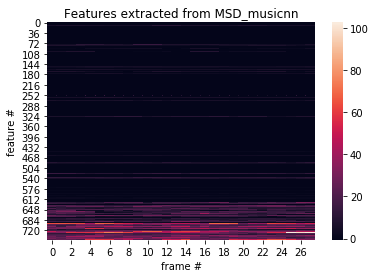

In [6]:
sns.heatmap(sample_features.T)
plt.title('Features extracted from MSD_musicnn')
plt.xlabel('frame #')
plt.ylabel('feature #')

Helper functions for computing song-tag predictions from frame-tag predictions and plotting confusion matrices.

In [7]:
from collections import Counter, defaultdict

def frame_predictions_to_song_predictions(y_labels: list, 
                                          fname_list: list, 
                                         ) -> dict:
    """
        Accepts a list of prediction labels `y_labels' and 
        the corresponding filename list `fname_list' and returns 
        a dict of frequencies for each label and each song.
        
        :param y_labels: list of tags (e.g. ['blues', 'blues', ...]) for each predicted frame
        :param fname_list: list of the corresponding filenames (e.g. ['blues.0000.wav',...])
        :returns: a dictionary of the form {'blues.0000.wav': 'blues', ...}
        
    """
    
    
    fname2tags = defaultdict(Counter)
    fname2tag  = dict()
    
    
    # First pass, get frequencies for each tag
    for n, fname in enumerate(fname_list):
        fname2tags[fname][y_labels[n]] += 1  
        
    # Second pass, get the most common tag for each song
    for fname in fname2tags:
        fname2tag[fname] = fname2tags[fname].most_common()[0][0]
        
    return fname2tag

def song_prediction_dict_to_lists(y_dict_true: dict,
                                  y_dict_pred: dict,
                                  fnames=None,
                                 ) -> (list,list,list):
    """
        Accepts two dictionaries of the form. {'blues.0000.wav' : blues, 'rock.0000.wav'}
        one holding the ground truth and one the predictions and returns two lists
        `y_true', `y_pred' aligned with a third list of filenames `fnames'.
        
        :param y_dict_true: dictionary of ground truth 
        :param y_dict_pred: dictionary of predicted values
        :param fnames: if not None, then it aligns predictions to that list.
        :returns: two lists `y_pred', `y_true' of predictions as well as 
        a third list `fnames' containing the filenames for both.
    """
    
    if not fnames:
        fnames = y_dict_true.keys()
    y_true = [y_dict_true[p] for p in fnames]
    y_pred = [y_dict_pred[p] for p in fnames]
    
    return y_true, y_pred, fnames

def get_song_taggrams(y_prob: np.ndarray,
                      fname_list: list) -> dict:
    """
        Gets the song taggram from a y_prob array 
    """
    
    fname2arrlists = defaultdict(list)
    fname2taggram = dict()
    
    # First pass, gather the probabilities for each frame
    # for each tag for each song.
    for n, fname in enumerate(fname_list):
        fname2arrlists[fname].append(y_prob[n, :])
        
    for fname in fname2arrlists:
        fname2taggram[fname] = np.vstack(fname2arrlists[fname])
        
    return fname2taggram

def taggrams_to_songs(taggrams: np.ndarray, idx2tag=idx2tag) -> dict:
    """
        Accepts a taggrams dict and returns a dict that
        maps each song to a tag
    """
    
    fname2song = dict()
    
    for fname in taggrams:
        fname2song[fname] = idx2tag[np.argmax(taggrams[fname].sum(axis=0))]
        
    return fname2song

def taggrams_to_proba(taggrams: np.ndarray, idx2tag=idx2tag) -> dict:
    """
        Accepts a taggrams dict and returns a dict that
        maps each song to a vector of probabilities. Used for
        computing auc scores and average precision score.
    """
    
    fname2proba = dict()
    
    for fname in taggrams:
        fname2proba[fname] = taggrams[fname].mean(axis=0)
        
    return fname2proba
    


def plot_confusion_matrix(y_true: list, y_pred: list) -> None:
    """
        Plots a confusion matrix using seaborn
        
        :param y_true: the true labels
        :param y_pred: the predicted labels
        :param labels: 
    """
    
    cf_mtx = confusion_matrix(y_true, y_pred)

    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix 
    cf_df = pd.DataFrame(cf_mtx, index=TAGS, columns=TAGS)
    sns.heatmap(cf_df, annot=True)
    
def plot_taggram(fname:str, taggrams:np.ndarray, labels=TAGS):
    """
        Plots a taggram 
    """
    sns.heatmap(taggrams[fname].T, yticklabels=labels)
    plt.title('Tag-gram for {}'.format(fname))
    plt.xlabel('feature #')
    plt.ylabel('tag')

## *Training* and model selection using the *validation* split.

Below we use the validation split to try different models. 

First try: musicnn (max_pool layer) + 128 PC + SVM with RBF kernel reports 77.24% accuracy
in https://github.com/jordipons/sklearn-audio-transfer-learning. Let's try that on our validation set.

              precision    recall  f1-score   support

       blues       0.61      0.82      0.70        17
   classical       1.00      0.95      0.98        21
     country       0.43      0.62      0.51        16
       disco       0.95      0.81      0.88        26
      hiphop       1.00      0.60      0.75        30
        jazz       0.94      0.70      0.80        23
       metal       1.00      0.87      0.93        23
         pop       0.38      0.45      0.42        11
      reggae       0.59      0.77      0.67        13
        rock       0.46      0.65      0.54        17

    accuracy                           0.74       197
   macro avg       0.74      0.72      0.72       197
weighted avg       0.80      0.74      0.75       197

CPU times: user 4min 42s, sys: 56.6 ms, total: 4min 42s
Wall time: 4min 40s


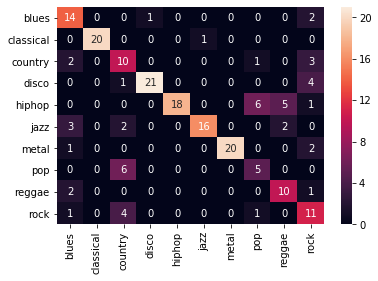

In [15]:
%%time

clf = Pipeline(steps=[
    ('pca', PCA(128, whiten=True)), 
    
    # While SVC is multiclass by default, we need to output probabilities in
    # order to be able to show taggrams, and compute average precision scores.
    ('svm', OneVsRestClassifier(
        SVC(kernel='rbf', C=1, gamma='scale', probability=True)
            )
    )
])


# Train classifier
y_val_score = clf.fit(X_train, y_train).decision_function(X_val)

# Predict validation 
y_pred = clf.predict(X_val)

# Convert to labels
y_pred_labels = [TAGS[p] for p in y_pred]
y_val_labels = [TAGS[p] for p in y_val]

# Convert frame-tag predictions to song-tag predictions 
s_pred_dict = frame_predictions_to_song_predictions(y_pred_labels, fnames_val)
s_val_dict = frame_predictions_to_song_predictions(y_val_labels, fnames_val)
s_val, s_pred, s_fnames = song_prediction_dict_to_lists(s_pred_dict, s_val_dict)

plot_confusion_matrix(s_val, s_pred)
print(classification_report(s_val, s_pred, ))

## Results reporting in the *testing* split for the SVM classifier

For MCG we usually report average precision, and ROC-AUC values, as well as show confusion matrices. 

              precision    recall  f1-score   support

       blues       0.77      0.32      0.45       868
   classical       1.00      1.00      1.00       868
     country       0.96      0.87      0.91       840
       disco       0.74      0.86      0.79       812
      hiphop       0.65      0.89      0.75       761
        jazz       0.57      1.00      0.73       756
       metal       0.90      1.00      0.95       756
         pop       0.78      0.70      0.74       840
      reggae       0.86      0.69      0.77       728
        rock       0.83      0.59      0.69       898

    accuracy                           0.79      8127
   macro avg       0.80      0.79      0.78      8127
weighted avg       0.81      0.79      0.78      8127

Average accuracy: 78.60
Average precision from PR curve: 0.8822
ROC-AUC: 0.9740
CPU times: user 46.9 s, sys: 40 ms, total: 47 s
Wall time: 45.9 s


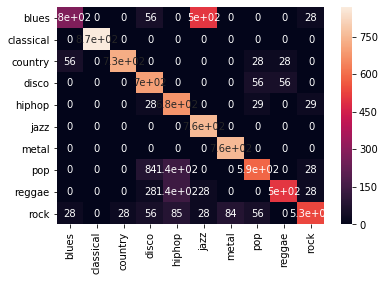

In [16]:
%%time 

# Predict testing 
y_pred = clf.predict(X_test)

# Convert to labels
y_pred_labels = [TAGS[p] for p in y_pred]
y_test_labels = [TAGS[p] for p in y_test]

# Taggrams require probabilities
y_proba = clf.predict_proba(X_test)

# Extract all taggrams for the predicted songs
taggrams_pred = get_song_taggrams(y_proba, fnames_test)
s_pred_dict = taggrams_to_songs(taggrams_pred)

# Convert frame-by-frame tagged labels to a dictionary that maps songs to tags
# for both the testing set and the predicted values
s_test_dict = frame_predictions_to_song_predictions(y_test_labels, fnames_test)
s_test, s_pred, s_fnames = song_prediction_dict_to_lists(s_test_dict, s_pred_dict, fnames_test )

# One-hot representation is used for computing average precision and auc scores 
s_test_onehot = np.zeros((len(s_test), len(TAGS)))
for n in range(len(s_test)):
    s_test_onehot[n,tag2idx[s_test[n]]] = 1.0
    
# Convert the predicted taggram to probabilities
s_pred_proba_dict = taggrams_to_proba(taggrams_pred)

s_pred_proba = []
for fname in fnames_test:
    s_pred_proba.append(s_pred_proba_dict[fname])
s_pred_proba = np.vstack(s_pred_proba)

plot_confusion_matrix(s_test, s_pred)
print(classification_report(s_test, s_pred))

print("Average accuracy: {:.2f}".format(100*accuracy_score(s_test, s_pred)))
print("Average precision from PR curve: {:.4f}".format(average_precision_score(s_test_onehot, s_pred_proba)))
print("ROC-AUC: {:.4f}".format(roc_auc_score(s_test_onehot, s_pred_proba)))

## Second try: `XGBoost`

`XGBoost` is an algorithm implementing ensembles of decision trees. It is supposed to be distributed and efficient to train.

Training parameters: musicnn (max_pool layer) + 128 PC + xgboost

              precision    recall  f1-score   support

       blues       0.52      0.80      0.63        15
   classical       1.00      0.95      0.98        21
     country       0.52      0.71      0.60        17
       disco       0.91      0.74      0.82        27
      hiphop       1.00      0.69      0.82        26
        jazz       0.94      0.80      0.86        20
       metal       1.00      0.83      0.91        24
         pop       0.46      0.60      0.52        10
      reggae       0.53      0.69      0.60        13
        rock       0.54      0.54      0.54        24

    accuracy                           0.74       197
   macro avg       0.74      0.74      0.73       197
weighted avg       0.79      0.74      0.75       197

CPU times: user 3min 28s, sys: 243 ms, total: 3min 29s
Wall time: 26.2 s


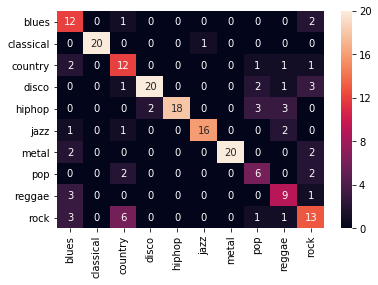

In [17]:
%%time

from xgboost import XGBClassifier

clf = Pipeline(steps=[
    ('pca', PCA(128, whiten=True)), 
    
    # We use the default options here
    ('xgb', OneVsRestClassifier(
                XGBClassifier()
            )
    )
])


# Train classifier
clf.fit(X_train, y_train)

# Predict validation 
y_pred = clf.predict(X_val)

# Convert to labels
y_pred_labels = [TAGS[p] for p in y_pred]
y_val_labels = [TAGS[p] for p in y_val]

# Convert frame-tag predictions to song-tag predictions 
s_pred_dict = frame_predictions_to_song_predictions(y_pred_labels, fnames_val)
s_val_dict = frame_predictions_to_song_predictions(y_val_labels, fnames_val)
s_val, s_pred, s_fnames = song_prediction_dict_to_lists(s_pred_dict, s_val_dict)

plot_confusion_matrix(s_val, s_pred)
print(classification_report(s_val, s_pred, ))

## Results reporting in the *testing* split

Again: average precision, and ROC-AUC values, as well as show confusion matrices. 

              precision    recall  f1-score   support

       blues       0.68      0.42      0.52       868
   classical       0.97      1.00      0.98       868
     country       0.87      0.87      0.87       840
       disco       0.81      0.86      0.83       812
      hiphop       0.63      0.89      0.74       761
        jazz       0.63      0.96      0.76       756
       metal       0.90      0.96      0.93       756
         pop       0.81      0.70      0.75       840
      reggae       0.84      0.62      0.71       728
        rock       0.76      0.59      0.67       898

    accuracy                           0.78      8127
   macro avg       0.79      0.79      0.78      8127
weighted avg       0.79      0.78      0.77      8127

Average accuracy: 78.26
Average precision from PR curve: 0.8861
ROC-AUC: 0.9707
CPU times: user 4.24 s, sys: 86.6 ms, total: 4.33 s
Wall time: 569 ms


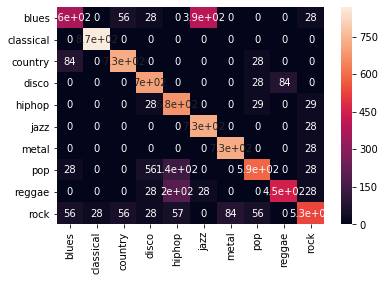

In [18]:
%%time

# Predict testing 
y_pred = clf.predict(X_test)

# Convert to labels
y_pred_labels = [TAGS[p] for p in y_pred]
y_test_labels = [TAGS[p] for p in y_test]

# Taggrams require probabilities
y_proba = clf.predict_proba(X_test)

# Extract all taggrams for the predicted songs
taggrams_pred = get_song_taggrams(y_proba, fnames_test)
s_pred_dict = taggrams_to_songs(taggrams_pred)

# Convert frame-by-frame tagged labels to a dictionary that maps songs to tags
# for both the testing set and the predicted values
s_test_dict = frame_predictions_to_song_predictions(y_test_labels, fnames_test)
s_test, s_pred, s_fnames = song_prediction_dict_to_lists(s_test_dict, s_pred_dict, fnames_test )

# One-hot representation is used for computing average precision and auc scores 
s_test_onehot = np.zeros((len(s_test), len(TAGS)))
for n in range(len(s_test)):
    s_test_onehot[n,tag2idx[s_test[n]]] = 1.0
    
# Convert the predicted taggram to probabilities
s_pred_proba_dict = taggrams_to_proba(taggrams_pred)

s_pred_proba = []
for fname in fnames_test:
    s_pred_proba.append(s_pred_proba_dict[fname])
s_pred_proba = np.vstack(s_pred_proba)

plot_confusion_matrix(s_test, s_pred)
print(classification_report(s_test, s_pred))

print("Average accuracy: {:.2f}".format(100*accuracy_score(s_test, s_pred)))
print("Average precision from PR curve: {:.4f}".format(average_precision_score(s_test_onehot, s_pred_proba)))
print("ROC-AUC: {:.4f}".format(roc_auc_score(s_test_onehot, s_pred_proba)))

## Results on the *testing* split

|Classifier                    |Avg. Acc| Avg. P| ROC-AUC| Time (training) | Time (testing) |
|------------------------------|--------|-------|--------|----   | ----|
|SVM(RBF,C=1)<sup>1</sup>|0.7724   | --    |  --    |      ---     |--- |
|SVM(RBF,C=1)  |         0.7860   | 0.8822      | 0.9740       |4m40s| 45.9s|
|XGBoost       |         0.7826   |  0.8861     | 0.9707       |26.2s| 569ms |

We achieve an average best accuracy of 78.60% which is more than the 77.24% reported in https://github.com/jordipons/sklearn-audio-transfer-learning. 

Also while avg. accuracy is better in the case of an SVM, XGBoost is 2 orders of magnitude faster regarding training and testing times, and should be the classifier chosen for production.

We observe that blues are easily confused for jazz. Pop and reggae can be sometimes also confused for hiphop. While these results are not entirely unsurprising (humans can also confuse jazz and blues) some study into this is warranted.

Taggrams are probabilities of each frame that the song is a specific tag. In the diagrams below lighter boxes mean higher probabilities. 

<sup>1</sup>https://github.com/jordipons/sklearn-audio-transfer-learning.

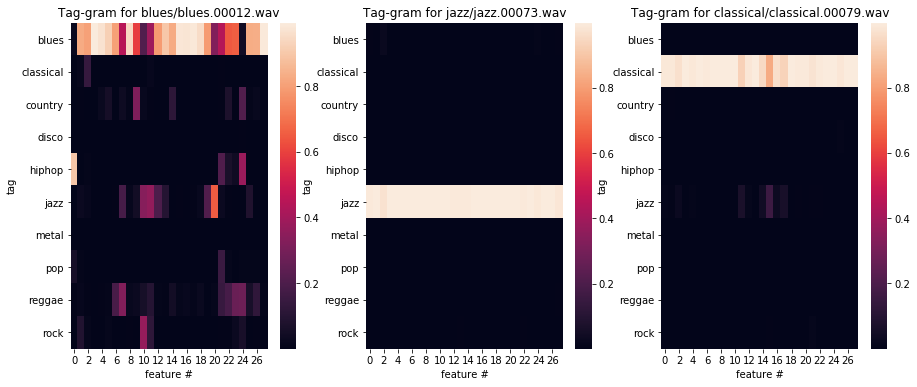

In [19]:
# Plot some taggrams
plt.figure(figsize=(15,6))

plt.subplot(1,3,1)
plot_taggram('blues/blues.00012.wav', taggrams_pred)
plt.subplot(1,3,2)
plot_taggram('jazz/jazz.00073.wav', taggrams_pred)
plt.subplot(1,3,3)
plot_taggram('classical/classical.00079.wav', taggrams_pred)

## Final step: Save the trained model 

We save the final classifier in order to use it for deployment. We used a OneVsRest classification scheme to be able to derive probabilities and scores and evaluate it. We save this and also the multi-class (stock) classifier directly (without the OVR wrapper) which might behave slightly differently but is a lot faster:

In [20]:
%%time

clf_ovr = Pipeline(steps=[
    ('pca', PCA(128, whiten=True)), 
    ('xgb', OneVsRestClassifier(
            XGBClassifier()
        )
    )
])

clf = Pipeline(steps=[
    ('pca', PCA(128, whiten=True)), 
    ('xgb', XGBClassifier()),
])

clf_ovr.fit(X_train, y_train)
clf.fit(X_train, y_train)

joblib.dump(clf_ovr, 'models/features_classifier_ovr.pkl')
joblib.dump(clf, 'models/features_classifier.pkl')

CPU times: user 7min, sys: 363 ms, total: 7min 1s
Wall time: 52.8 s


['models/features_classifier.pkl']

Below we compare times for the OVR and the stock classifiers:

In [21]:
%%time
y_pred = clf.predict(X_test)

CPU times: user 838 ms, sys: 3.36 ms, total: 841 ms
Wall time: 105 ms


In [22]:
%%time
y_pred = clf_ovr.predict(X_test)

CPU times: user 1.49 s, sys: 26.6 ms, total: 1.52 s
Wall time: 190 ms


## Demo: Steps to evaluate an audio file

In [23]:
%%time

# Specify filename 
fname = 'data/genres/classical/classical.00006.wav'

# Extract the `max_pool' features using musicnn
_, _, features           = extractor(fname, 
                           model='MSD_musicnn', 
                           input_overlap=1,
                           extract_features=True)

maxpool_features = features['max_pool']

# Classify each feature with the trained classifier
y_pred = clf.predict(maxpool_features)

# Assign a string tag (e.g. 'classical' instead of 1) to each predicted class
y_pred_labels = [idx2tag[n] for n in y_pred]

# The assigned genre is the most common tag
tag = Counter(y_pred_labels).most_common()[0][0]

print('Assigned genre:', tag)

Computing spectrogram (w/ librosa) and tags (w/ tensorflow).. done!
Assigned genre: classical
CPU times: user 5.39 s, sys: 1.88 s, total: 7.27 s
Wall time: 18.5 s
